# using tensorflow 1.14.0

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.14.0

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 109.2MB 97kB/s 
     |████████████████████████████████| 491kB 44.5MB/s 
     |████████████████████████████████| 3.2MB 37.2MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2


# **importing the required libraries**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten,Input
from keras import backend as K
from keras.models import Model, load_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.spatial import distance
from sklearn.decomposition import PCA
from numpy import linalg as LA
from keras.objectives import categorical_crossentropy
from sklearn.metrics import roc_curve, auc
import math
from scipy.stats import pearsonr
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import csv
from sklearn import metrics
import tensorflow as tf
import tensorflow.contrib.layers as tl
import numpy as np
import pandas as pd 
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# loading the dataset

In [ ]:
X = pd.read_csv('/content/drive/My Drive/Crime Prediction/crime_prep.csv',delimiter=',')
print(X.shape)
X[0:5]

(1994, 128)


,target,v_cont_0,v_cat_0,v_cat_1,v_cat_2,v_cat_3,v_cont_5,v_cont_6,v_cont_7,v_cont_8,v_cont_9,v_cont_10,v_cont_11,v_cont_12,v_cont_13,v_cont_14,v_cont_15,v_cont_16,v_cont_17,v_cont_18,v_cont_19,v_cont_20,v_cont_21,v_cont_22,v_cont_23,v_cont_24,v_cont_25,v_cont_26,v_cont_27,v_cont_28,v_cont_29,v_cont_30,v_cont_31,v_cont_32,v_cont_33,v_cont_34,v_cont_35,v_cont_36,v_cont_37,v_cont_38,...,v_cont_87,v_cont_88,v_cont_89,v_cont_90,v_cont_91,v_cont_92,v_cont_93,v_cont_94,v_cont_95,v_cont_96,v_cont_97,v_cont_98,v_cont_99,v_cont_100,v_cont_101,v_cont_102,v_cont_103,v_cont_104,v_cont_105,v_cont_106,v_cont_107,v_cont_108,v_cont_109,v_cont_110,v_cont_111,v_cont_112,v_cont_113,v_cont_114,v_cont_115,v_cont_116,v_cont_117,v_cont_118,v_cont_119,v_cont_120,v_cont_121,v_cont_122,v_cont_123,v_cont_124,v_cont_125,v_cont_126
0,0.20,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,...,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,0.67,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,...,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN
2,0.43,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,...,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN
3,0.12,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,...,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN
4,0.03,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,...,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN


# **Data Cleaning**

Missing data can either be filled with the means of the features or maybe 0 to ignore them or even other data imputation techniques to predict the missing values
In this case the mean of the features is taken for the missing values.

In [ ]:
print(len(X['v_cat_2'].unique()))
X = X.fillna(X.mean())
del X['v_cat_2']
del X['v_cat_3']
Y = X['target']
del X['target']
X.head()

1828


,v_cont_0,v_cat_0,v_cat_1,v_cont_5,v_cont_6,v_cont_7,v_cont_8,v_cont_9,v_cont_10,v_cont_11,v_cont_12,v_cont_13,v_cont_14,v_cont_15,v_cont_16,v_cont_17,v_cont_18,v_cont_19,v_cont_20,v_cont_21,v_cont_22,v_cont_23,v_cont_24,v_cont_25,v_cont_26,v_cont_27,v_cont_28,v_cont_29,v_cont_30,v_cont_31,v_cont_32,v_cont_33,v_cont_34,v_cont_35,v_cont_36,v_cont_37,v_cont_38,v_cont_39,v_cont_40,v_cont_41,...,v_cont_87,v_cont_88,v_cont_89,v_cont_90,v_cont_91,v_cont_92,v_cont_93,v_cont_94,v_cont_95,v_cont_96,v_cont_97,v_cont_98,v_cont_99,v_cont_100,v_cont_101,v_cont_102,v_cont_103,v_cont_104,v_cont_105,v_cont_106,v_cont_107,v_cont_108,v_cont_109,v_cont_110,v_cont_111,v_cont_112,v_cont_113,v_cont_114,v_cont_115,v_cont_116,v_cont_117,v_cont_118,v_cont_119,v_cont_120,v_cont_121,v_cont_122,v_cont_123,v_cont_124,v_cont_125,v_cont_126
0,8,58.826829,46188.336597,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,...,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.03000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000
1,53,58.826829,46188.336597,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,...,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
2,24,58.826829,46188.336597,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,...,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
3,34,5.000000,81440.000000,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,...,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
4,42,95.000000,6096.000000,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,...,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078


# Standardise v_cont_0, v_cat_0, v_cat_1 columns

In [ ]:
X['v_cat_0'] = StandardScaler().fit_transform(X['v_cat_0'].values.reshape(-1, 1))
X['v_cat_1'] = StandardScaler().fit_transform(X['v_cat_1'].values.reshape(-1, 1))
X['v_cont_0'] = StandardScaler().fit_transform(X['v_cont_0'].values.reshape(-1, 1))
X.head()

,v_cont_0,v_cat_0,v_cat_1,v_cont_5,v_cont_6,v_cont_7,v_cont_8,v_cont_9,v_cont_10,v_cont_11,v_cont_12,v_cont_13,v_cont_14,v_cont_15,v_cont_16,v_cont_17,v_cont_18,v_cont_19,v_cont_20,v_cont_21,v_cont_22,v_cont_23,v_cont_24,v_cont_25,v_cont_26,v_cont_27,v_cont_28,v_cont_29,v_cont_30,v_cont_31,v_cont_32,v_cont_33,v_cont_34,v_cont_35,v_cont_36,v_cont_37,v_cont_38,v_cont_39,v_cont_40,v_cont_41,...,v_cont_87,v_cont_88,v_cont_89,v_cont_90,v_cont_91,v_cont_92,v_cont_93,v_cont_94,v_cont_95,v_cont_96,v_cont_97,v_cont_98,v_cont_99,v_cont_100,v_cont_101,v_cont_102,v_cont_103,v_cont_104,v_cont_105,v_cont_106,v_cont_107,v_cont_108,v_cont_109,v_cont_110,v_cont_111,v_cont_112,v_cont_113,v_cont_114,v_cont_115,v_cont_116,v_cont_117,v_cont_118,v_cont_119,v_cont_120,v_cont_121,v_cont_122,v_cont_123,v_cont_124,v_cont_125,v_cont_126
0,-1.261697,0.000000,0.000000,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,...,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.03000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000
1,1.483304,0.000000,0.000000,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,...,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
2,-0.285697,0.000000,0.000000,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,...,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
3,0.324303,-0.664357,2.178117,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,...,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078
4,0.812304,0.446467,-2.477211,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,...,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.069655,0.217461,0.924734,0.246332,0.097994,0.215204,0.343636,0.217492,0.689404,0.726959,0.22047,0.134859,0.114859,0.259185,0.075549,0.55605,0.305987,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078


# **Principal Component Analysis**

No handles with labels found to put in legend.


(1994, 125)
(125, 125)


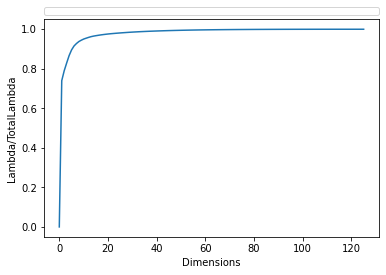

In [ ]:
print(X.shape)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,random_state=42)

Covariance = np.dot(X_train.T,X_train)
print(Covariance.shape)

Lambda, e = LA.eigh(Covariance)
Lambda = Lambda.reshape(Lambda.shape[0],1)
Lambda = sorted(Lambda,reverse=True)
TotalLambda = np.sum(Lambda)
LambdaProp = []
for i in range(X_train.shape[1]):
    temp = np.sum(Lambda[0:i])*1.0/TotalLambda
    LambdaProp.append(temp)

Dim = np.linspace(0, X_train.shape[1], X_train.shape[1])

plt.plot(Dim,LambdaProp)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Dimensions')
plt.ylabel('Lambda/TotalLambda')
plt.show()

In [ ]:
X1 = X
Y1 = Y

for i in (range(1,100)):
    print(i)
    NewFeatureSet = np.dot(X1,e[:,125-i:125])
    print (NewFeatureSet.shape)
    X_train,X_test,Y_train,Y_test = train_test_split(NewFeatureSet,Y1,test_size = 0.2,random_state=42)
    #Normal Linear Regression
    regr = linear_model.LinearRegression(normalize = True)
    regr.fit(X_train,Y_train)
    Y_pred = regr.predict(X_test)
    Weights = regr.coef_
    print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
    print('Variance/R2 score: %.2f' % r2_score(Y_test, Y_pred))

1
(1994, 1)
RMSE 0.22
Variance/R2 score: -0.00
2
(1994, 2)
RMSE 0.21
Variance/R2 score: 0.04
3
(1994, 3)
RMSE 0.17
Variance/R2 score: 0.39
4
(1994, 4)
RMSE 0.16
Variance/R2 score: 0.48
5
(1994, 5)
RMSE 0.15
Variance/R2 score: 0.52
6
(1994, 6)
RMSE 0.15
Variance/R2 score: 0.52
7
(1994, 7)
RMSE 0.15
Variance/R2 score: 0.54
8
(1994, 8)
RMSE 0.15
Variance/R2 score: 0.55
9
(1994, 9)
RMSE 0.14
Variance/R2 score: 0.59
10
(1994, 10)
RMSE 0.14
Variance/R2 score: 0.61
11
(1994, 11)
RMSE 0.14
Variance/R2 score: 0.61
12
(1994, 12)
RMSE 0.13
Variance/R2 score: 0.62
13
(1994, 13)
RMSE 0.13
Variance/R2 score: 0.63
14
(1994, 14)
RMSE 0.13
Variance/R2 score: 0.63
15
(1994, 15)
RMSE 0.13
Variance/R2 score: 0.63
16
(1994, 16)
RMSE 0.13
Variance/R2 score: 0.63
17
(1994, 17)
RMSE 0.13
Variance/R2 score: 0.63
18
(1994, 18)
RMSE 0.13
Variance/R2 score: 0.64
19
(1994, 19)
RMSE 0.13
Variance/R2 score: 0.64
20
(1994, 20)
RMSE 0.13
Variance/R2 score: 0.64
21
(1994, 21)
RMSE 0.13
Variance/R2 score: 0.64
22
(1994,

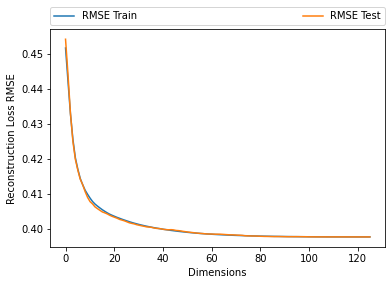

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,random_state=42)
RMSETrain =[]
RMSETest =[]
VarainceRatio = []
Dim = np.linspace(0, X_train.shape[1], X_train.shape[1])
for i in range(1,X_train.shape[1]+1):
    pca = PCA(n_components = i)
    pca.fit(X_train)
    VarainceRatio.append(pca.explained_variance_ratio_)
    X_trainhat = np.dot(pca.transform(X_train)[:,:i], pca.components_[:i,:])
    RMSETrain.append(math.sqrt(mean_squared_error(X_train,X_trainhat)))
    X_testhat = np.dot(pca.transform(X_test)[:,:i], pca.components_[:i,:])
    RMSETest.append(math.sqrt(mean_squared_error(X_test,X_testhat)))
    
plt.plot(Dim,RMSETrain,label="RMSE Train")
plt.plot(Dim,RMSETest,label="RMSE Test")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Dimensions')
plt.ylabel('Reconstruction Loss RMSE')
plt.show()

In [ ]:
X1 = X
Y1 = Y
for i in range(1,15):
    pca = PCA(n_components = i)
    X_1 = pca.fit_transform(X1)
    #VarainceRatio.append(pca.explained_variance_ratio_)
    print (X_1)
    print ("no of componenets",i)
    print ("predict for transformed data")
    
    X_train,X_test,Y_train,Y_test = train_test_split(X_1,Y1,test_size = 0.2,random_state=42)
    #Normal Linear Regression
    regr = linear_model.LinearRegression(normalize = True)
    regr.fit(X_train,Y_train)
    Y_pred = regr.predict(X_test)
    Weights = regr.coef_
    print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
    print('Variance/R2 score: %.2f' % r2_score(Y_test, Y_pred))

[[-0.83893174]
 [ 0.91684946]
 [ 0.21196309]
 ...
 [-0.6326288 ]
 [-0.63799423]
 [-1.45620074]]
no of componenets 1
predict for transformed data
RMSE 0.22
Variance/R2 score: -0.02
[[-0.83893174  0.19106065]
 [ 0.91684946 -0.35978791]
 [ 0.21196309  0.41829515]
 ...
 [-0.6326288   0.70376198]
 [-0.63799423 -0.32252534]
 [-1.45620074  1.73787882]]
no of componenets 2
predict for transformed data
RMSE 0.16
Variance/R2 score: 0.49
[[-0.83893174  0.19106065  0.39788124]
 [ 0.91684946 -0.35978791 -0.32442181]
 [ 0.21196309  0.41829515 -0.13784697]
 ...
 [-0.6326288   0.70376198  1.6834653 ]
 [-0.63799423 -0.32252535  1.46103493]
 [-1.45620074  1.73787882  0.58259365]]
no of componenets 3
predict for transformed data
RMSE 0.16
Variance/R2 score: 0.48
[[-0.83893174  0.19106065  0.39788124  0.28589089]
 [ 0.91684946 -0.35978791 -0.32442181 -0.04681389]
 [ 0.21196309  0.41829515 -0.13784697 -0.30614275]
 ...
 [-0.6326288   0.70376198  1.6834653  -1.63788756]
 [-0.63799423 -0.32252534  1.46103493

Feature engineering using **Pearson**'**s** **Coefficient**

In [ ]:
X = (X - X.mean())
Matrix = X.values
#print TrainX['ALSQM_Count']
r=[]
p=[]
for i in range(X.shape[1]):
    t1,t2 = pearsonr(Matrix[:,i],Y)
    #print t1,i,
    r.append((t1,i,X.columns[i],t2))
r.sort()

37


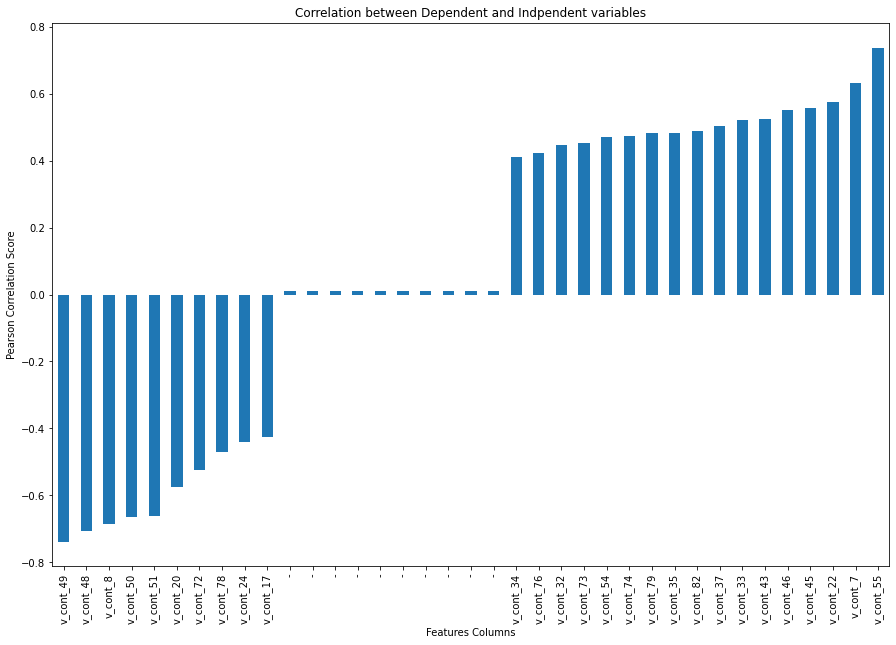

In [ ]:
frequencies = []
labels =[]
count=0
for ind,x in enumerate(r):
    if(x[0]<-0.4 or x[0]>0.4):
        frequencies.append(x[0])
        labels.append(x[2])
    else:
        if count<10:
            labels.append('-')
            frequencies.append(0.01)
            count+=1
print (len(frequencies))
freq_series = pd.Series(frequencies)
x_labels = range(len(freq_series))
plt.figure(figsize=(15, 10))
ax = freq_series.plot(kind='bar')
ax.set_title('Correlation between Dependent and Indpendent variables')
ax.set_xlabel('Features Columns')
ax.set_ylabel('Pearson Correlation Score')
rects = ax.patches
ax.set_xticklabels(labels)
plt.show()

In [ ]:
IndList =[]
for ind,x in enumerate(r):
    if(x[0]<-0.4 or x[0]>0.4):
        IndList.append(x[1])
CorrList =[]
CorrMatrix = np.zeros((len(IndList),len(IndList)))
Cols =[]
for i in range(len(IndList)):
    Cols.append(X.columns[IndList[i]])
    for j in range(len(IndList)):
        t1,t2 = pearsonr(Matrix[:,IndList[i]],Matrix[:,IndList[j]])
        CorrList.append((t1,IndList[i],X.columns[IndList[i]],IndList[j],X.columns[IndList[j]],t2))
        CorrMatrix[i][j] = t1
print (CorrMatrix.shape)

(27, 27)


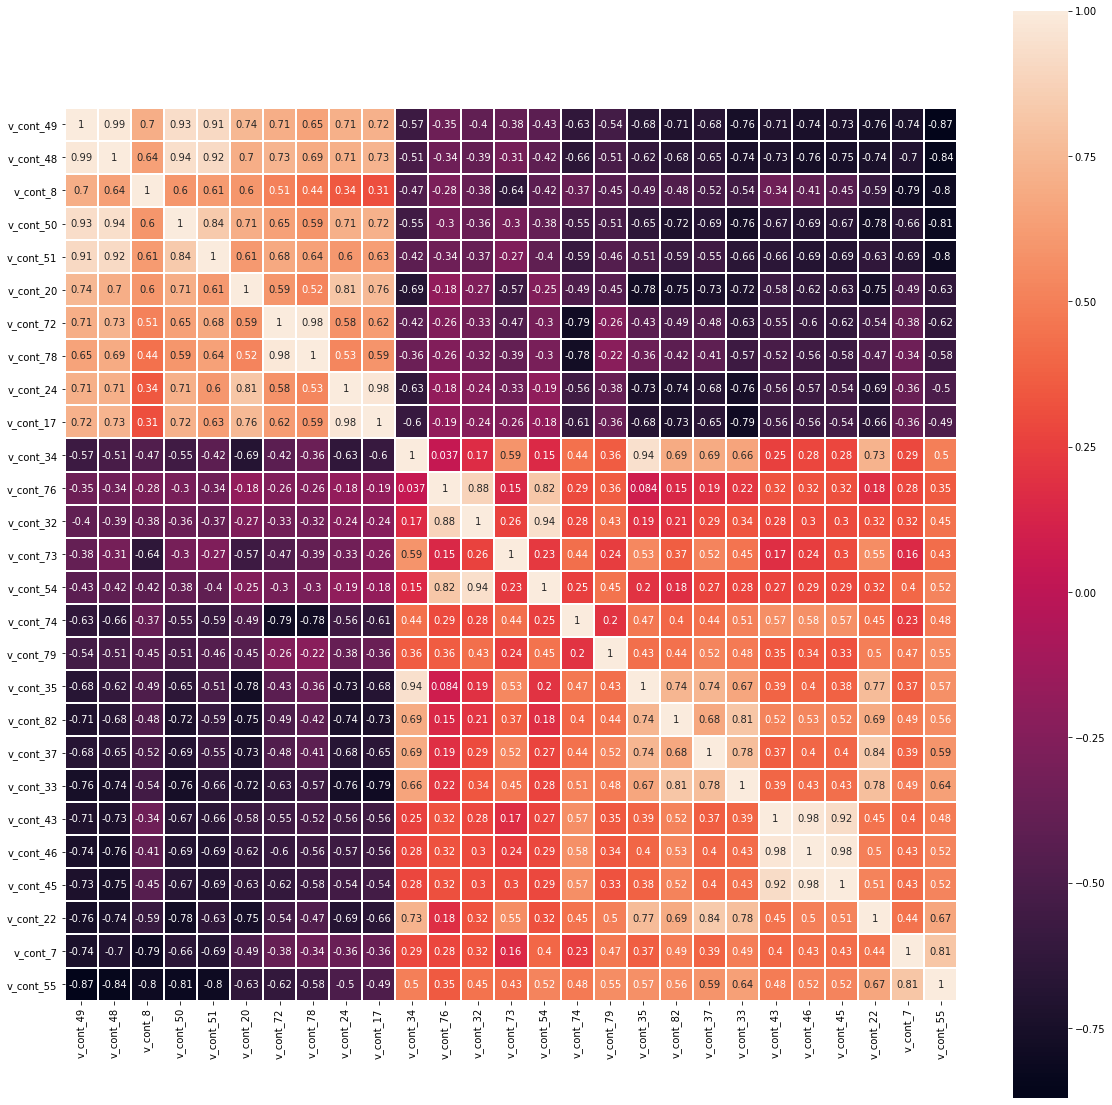

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sb.heatmap(CorrMatrix, 
        xticklabels=Cols,
        yticklabels=Cols,linewidths=1,annot=True, ax=ax,square =True)

plt.show()

# **Model Development and Performance**

In [ ]:
print (IndList)
t=[]
for i in IndList:
    t.append(X.columns[i])
print (t)
FinalTrainSet = np.zeros((len(IndList),Matrix.shape[0]))
for ind,i in enumerate(IndList):
    FinalTrainSet[ind] = (Matrix[:,i])
FinalTrainSet = FinalTrainSet.T
print (FinalTrainSet.shape)
print (Y.shape)

[47, 46, 6, 48, 49, 18, 70, 76, 22, 15, 32, 74, 30, 71, 52, 72, 77, 33, 80, 35, 31, 41, 44, 43, 20, 5, 53]
['v_cont_49', 'v_cont_48', 'v_cont_8', 'v_cont_50', 'v_cont_51', 'v_cont_20', 'v_cont_72', 'v_cont_78', 'v_cont_24', 'v_cont_17', 'v_cont_34', 'v_cont_76', 'v_cont_32', 'v_cont_73', 'v_cont_54', 'v_cont_74', 'v_cont_79', 'v_cont_35', 'v_cont_82', 'v_cont_37', 'v_cont_33', 'v_cont_43', 'v_cont_46', 'v_cont_45', 'v_cont_22', 'v_cont_7', 'v_cont_55']
(1994, 27)
(1994,)


# **Linear Regression**

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(FinalTrainSet,Y,test_size = 0.3,random_state=42)
#Normal Linear Regression
clf = linear_model.LinearRegression(normalize = True)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
Weights = clf.coef_
print (Weights)
print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
print('Variance/R2 score: %.2f' % r2_score(Y_test, Y_pred))

# Linear Regression With Ridge regularisation
clf = linear_model.Ridge(alpha = 0.1,normalize = True)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
print('Variance/R2 score: %.2f' % r2_score(Y_test, Y_pred))


# Linear Regression With Lasso regularisation
clf = linear_model.Lasso(alpha = 0.1,normalize = True)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
print('Variance/R2 score: %.2f' % r2_score(Y_test, Y_pred))


[-0.06986744 -0.20319033  0.00282052 -0.0764294  -0.00365693 -0.11640938
 -0.3154949   0.35358964  0.21298279 -0.04158515 -0.16352962  0.26255075
  0.12639153  0.2220687  -0.23364425  0.10495532  0.04729825  0.11573447
  0.02870576 -0.05019055 -0.06960878  0.4324694  -0.61741931  0.26619755
  0.05778619  0.19690957  0.16119416]
RMSE 0.13
Variance/R2 score: 0.64
RMSE 0.13
Variance/R2 score: 0.64
RMSE 0.22
Variance/R2 score: -0.01


# **Neural Nets**

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(FinalTrainSet,Y,test_size = 0.3,random_state=42)
InputWidth = X_train.shape[1]
K.clear_session()
model = Sequential()
model.add(Dense(128, input_shape = (InputWidth,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
#model.add(Dense(InputWidth, activation='relu'))
print (model.summary())
# Compile model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
op = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=150, batch_size=64, verbose=2).history
y_pred = model.predict(X_test)
print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()



Train on 1395 samples, validate on 599 samples
Epoch 1/150
 - 0s - loss: 0.1127 - accuracy: 0.0036 - val_loss: 0.0952 - val_accuracy: 0.0083
Epoch 2/150
 - 0s - loss: 0.1063 - accuracy: 0.0043 - val_loss: 0.0805 - val_accuracy: 0.0083
Epoch 3/150
 - 0s - loss: 0.0868 - accuracy: 0.0036 - val_loss: 0.0464 - val_accuracy: 0.0083
Epoch 4/150
 - 0s - loss: 0.0598 - accuracy: 0.0036 - val_loss: 0.0327 - val_accuracy: 0.0083
Epoch 5/150
 - 0s - loss: 0.0504 - accuracy: 0.0050 - val_loss: 0.0283 - val_accuracy: 0.0083
Epoch 6/150
 - 0s - loss: 0.0433 - accuracy: 0.0100 - val_loss: 0.0259 - val_accuracy: 0.0100
Epoch 7/150
 - 0s - loss: 0.0408 - accuracy: 0.0122 - val_loss: 0.0242 - val_accuracy: 0.0117
Epoch 8/150
 - 0s - loss: 0.0391 - accuracy: 0.0115 - val_loss: 0.0230 - val_accuracy: 0.0117
Epoch 9/150
 - 0s - loss: 0.0362 - accuracy: 0.0165 - val_loss: 0.0221 - val_accuracy: 0.0117
Epoch 10/150
 - 0s - loss: 0.0341 - accuracy: 0.0151 - val_loss: 0.0214 - val_accuracy: 0.0150
Epoch 11/15

# FNN (Feedforward Neural Networks) doesnt perform as well possibly due to the limited number of training samples

In [ ]:
HighCorrTuples =[]
LowCorrTuples=[]
Col =[]
ht ={}
CorrCopy = copy.deepcopy(CorrList)
for var in CorrCopy:
    if((var[0]>=0.8 or var[0]<=-0.8) and var[1]!=var[3]):
        if(var[1] not in ht or var[3] not in ht):
            print (var)
            ht[var[3]] =0
    else:
        LowCorrTuples.append(var)
print (len(ht))
FinalFeatureSet =[]
print (len(CorrCopy))
for index,var in enumerate(CorrCopy):
    if(not(var[1] in ht or var[3] in ht)):
        #print var
        FinalFeatureSet.append(var)
print (len(CorrList))
print (len(CorrCopy))
print (len(FinalFeatureSet))

(0.9853580281880351, 47, 'v_cont_49', 46, 'v_cont_48', 0.0)
(0.931154516334042, 47, 'v_cont_49', 48, 'v_cont_50', 0.0)
(0.9076518065031174, 47, 'v_cont_49', 49, 'v_cont_51', 0.0)
(-0.8701983204454442, 47, 'v_cont_49', 53, 'v_cont_55', 0.0)
(0.9853580281880351, 46, 'v_cont_48', 47, 'v_cont_49', 0.0)
(-0.803451907298916, 6, 'v_cont_8', 53, 'v_cont_55', 0.0)
(0.8132433874202087, 18, 'v_cont_20', 22, 'v_cont_24', 0.0)
(0.9818985170148149, 70, 'v_cont_72', 76, 'v_cont_78', 0.0)
(0.9818985170148149, 76, 'v_cont_78', 70, 'v_cont_72', 0.0)
(0.8132433874202087, 22, 'v_cont_24', 18, 'v_cont_20', 0.0)
(0.9776158180285812, 22, 'v_cont_24', 15, 'v_cont_17', 0.0)
(0.943850337964961, 32, 'v_cont_34', 33, 'v_cont_35', 0.0)
(0.881445623641026, 74, 'v_cont_76', 30, 'v_cont_32', 0.0)
(0.8226685567453996, 74, 'v_cont_76', 52, 'v_cont_54', 0.0)
(0.881445623641026, 30, 'v_cont_32', 74, 'v_cont_76', 0.0)
(0.943850337964961, 33, 'v_cont_35', 32, 'v_cont_34', 0.0)
(0.8137998648445636, 80, 'v_cont_82', 31, 'v_c

3


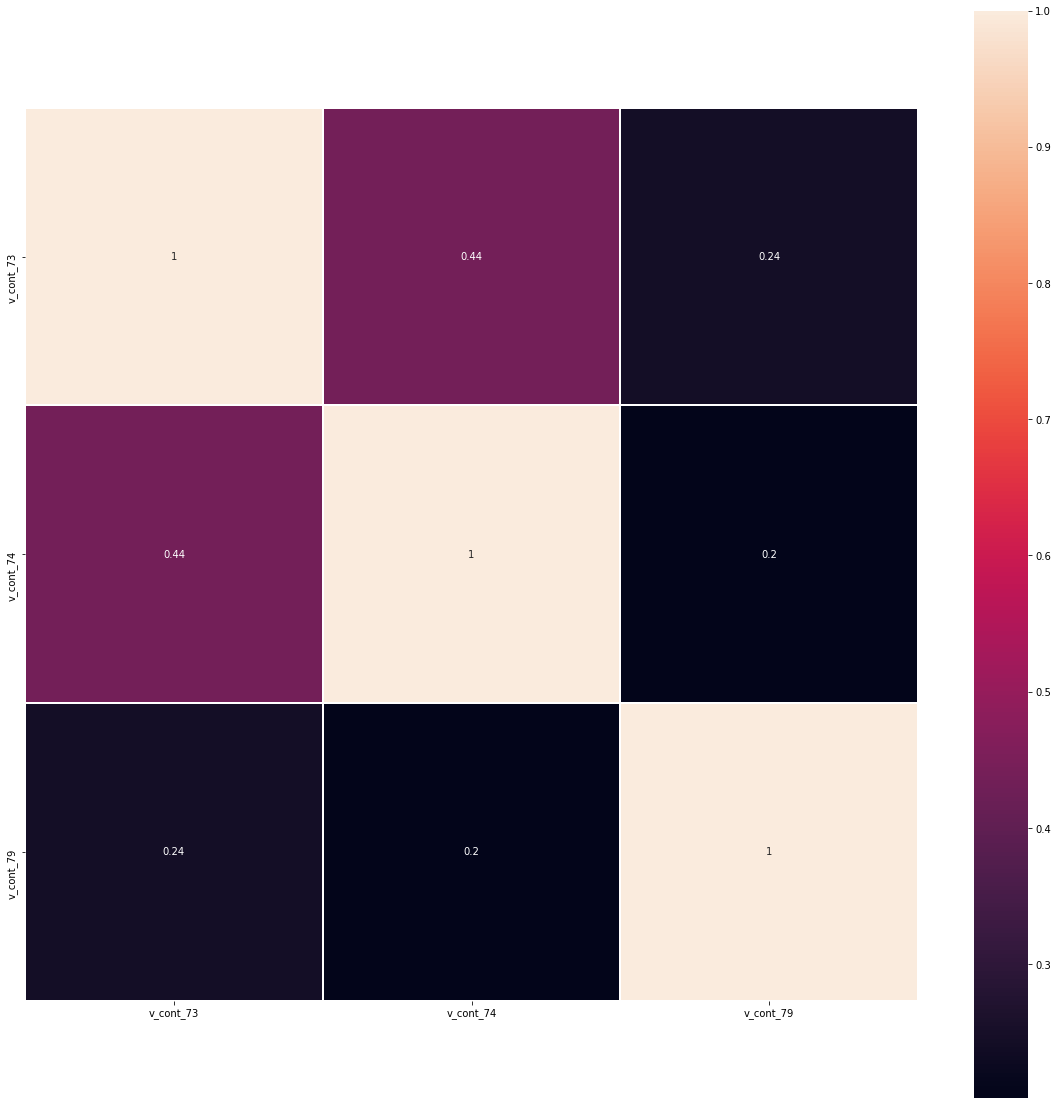

In [ ]:
Indfor ={}
for ind,x in enumerate(FinalFeatureSet):
    if(x[1] not in Indfor):
        Indfor[x[1]] = x[1]
print (len(Indfor))
IndforCor =[]
for key,val in Indfor.items():
    IndforCor.append(val)
Cols=[]
FinalcorMatrix = np.zeros((len(Indfor),len(Indfor)))
for i in range(FinalcorMatrix.shape[0]):
    Cols.append(X.columns[IndforCor[i]])
    for j in range(FinalcorMatrix.shape[1]):
        t1,t2 = pearsonr(Matrix[:,IndforCor[i]],Matrix[:,IndforCor[j]])
        FinalcorMatrix[i][j] = t1
        
fig, ax = plt.subplots(figsize=(20,20)) 
sb.heatmap(FinalcorMatrix, 
        xticklabels=Cols,
        yticklabels=Cols,linewidths=1,annot=True, ax=ax,square =True)

plt.show()

In [ ]:
print(IndforCor)

[71, 72, 77]


# **Linear regression on the remaining features**

In [ ]:
FinalTrainSetForTrain = np.zeros((3,Matrix.shape[0]))
for ind,k in enumerate(IndforCor):
    FinalTrainSetForTrain[ind] = (Matrix[:,k]) 
FinalTrainSetForTrain = FinalTrainSetForTrain.T
X_train,X_test,Y_train,Y_test = train_test_split(FinalTrainSetForTrain,Y,test_size = 0.3,random_state=42)
#Normal Linear Regression

clf = linear_model.LinearRegression(normalize = True)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
Weights = clf.coef_
print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))

# Linear Regression With Ridge regularisation
clf = linear_model.Ridge(alpha = 0.1,normalize = True)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))


# Linear Regression With Lasso regularisation
clf = linear_model.Lasso(alpha = 0.1,normalize = True)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print ("RMSE %.2f" % math.sqrt(mean_squared_error(Y_test,Y_pred)))
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))


RMSE 0.17
Variance score: 0.42
RMSE 0.17
Variance score: 0.42
RMSE 0.22
Variance score: -0.01
